
# Decomposing/attributing the impact of a shock 

When working with a model it is often useful to have a better sense of the contribution of different channels to a final result.  For example, an increase in interest rates will tend to reduce investment and consumer demand -- contributing to a reduction in GDP. At the same time, lower inflation as the higher interest rate takes effect will tend to work in the opposite direction. 

The `tracedep()` and `tracepre()` methods introduced in the previous section give a sense of impacts, but the `modelflow` methods `.dekomp()` and `.totdif()` take that one step further by calculating the  contribution of each channel to the overall result.



## Prepare the workspace

As always before running `modelflow` the python environment needs to be initialized and libraries to be used imported.

In [3]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib
import warnings
#warnings.filterwarnings("ignore")

In [5]:
import pandas as pd

# Modules from Modelflow 
from modelclass import model 

# optional functionalities 
model.widescreen()
model.scroll_off()

# Output compatabiltity with LaTeX 
latex=True

## Load the existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions: 

 - Loads model and simulates to establish a baseline.
 - Creates a dataframe with a tax rate of 29 USD/Ton for carbon emission for 3 sectors.
 - Simulates the new experiment. 
  

In [8]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")
result = mpak(alternative,2020,2100,keep='Carbon tax nominal 30',ljit=False,nfirst=800,maxiteration=1000) # simulates the model 

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim



## The mathematics of attribution

At its root the idea of attribution is simply taking the total derivative of the model to identify the sensitivity of the equation we are interested in to changes elsewhere in the model and then combine that with the changes in other variables. 

Take a variable y that is a function of two other variables a and b.  In the model the relationship might be written as:


$y = f(a,b)$

If there are two observations 

\begin{eqnarray}
y_0 = f(a_0,b_0)\\
y_1 = f(a_1,b_1)
\end{eqnarray}

then we also have the change in all three variables $\Delta y, \Delta a, \Delta b$ and the total derivative of y can be written as:


$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

The first expresion can be called $\Omega_a$ or the contribution of changes in a to changes in y, and the second $\Omega_b$,  or the contribution of changes in b to changes in y.  


`Modelflow` performs a numerical approximation of $\Omega_a$ and $\Omega_b$ by performing two runs of the $f()$:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

and calculates $\Omega_a$ and $\Omega_b$ as:

\begin{eqnarray}  
\Omega a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega a + \Omega b -(y_1 - y_0) 
\end{eqnarray}

If the model is fairly linear, the residual will be small. 



## Model attribution or  single equation attribution?

Above the relationship between y, a, and b was summarized by the function f(). 

$f(a,b)$ could represent **a single equation** in the model or it could represent **the entire model**. 

In the a **single equation** instance, $\Delta a$ and $\Delta b$ would be treated as exogenous variables in the attribution calculation as they are both on the right hand side of the equation. It does not matter if $a$ and $b$ are endogenous of exogenous variables in the complete model. 

In the the **entire model** instance $a$ and $b$ are exogenous variables in the model, in addition it only makes sense to look at the exogenous variables which has changed between the experiments. That is $\Delta a \neq 0$ and $\Delta b \neq 0$

Assume the simple equation example such that  $a$ and $b$ are simple variables. When $\Delta y$, $\Delta a$ and $\Delta b$ reflect the difference across scenarios (say the value of the three variables in `.lastdf` less the value in `.basedf` then;

$\Omega_a$, $\Omega_b$ are the absolute contribution of a and b to the change in y, and 
$100*\bigg[\cfrac{\Omega_a}{\Delta y}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y}\bigg]$ are the share of the change in y explained by a and b respectively.

If $\Delta y$, $\Delta a$ and $\Delta b$ are the changes over time ($\Delta y_t=y_t-y_{t-1}$), then $\Omega_a$, $\Omega_b$ are the contributions of a and b to the rate of growth of y, while $100*\bigg[\cfrac{\Omega_a}{\Delta y_{t-1}}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y_{t-1}}\bigg]$ are are the contributions of a and b to the rate of growth of y.







## Decomposing the changes in a single endogenous variable - formula attribution

The `modelflow` method `.dekomp()` isd used to calculate the contribution of different RHS variables to the change in an endogenous variable. Moreover the function is 
to create input to more high level functions used for visualizing  the output from   `.dekomp()` 

This method utilizes that each model object always stores the initial and most recent simulation result in two dataframes called `.basedf` and `.lastdf`. The model object also all contains the equations of the model. 

## Call foundation attribution routine 
This is the routine which calculates the attribution. 

### The output of the `dekomp()` method

The `dekomp()` method calculates the contribution to changes in the level of the dependent variables in a given equation. It does not calculate the contributions the RHS variables.


The results of the `.dekomp` command are divided into 5 separate tables.

1. The first table of output shows the changes that are to be explained 
 - In this example **The changes are  drawn from the most recent solution, i.e. from the `.lastdf` and the `.basedf` dataFrames** of the model object. 
 - When doing a time attribution is performed the **changes is the changes from year to year in `.lastdf`**
2. The second table shows the changes between the contributions of the LHS variables to the changes in the RHS variable.  Because this equation is an additive identity, these amount to the changes in each of the variables themselves. 
3. the third table expresses these changes as a share of the total change.
4. The fourth table express the growth rates and the changes in growth rates. 
5. The last shows the contributions to these changes from the change in the right hand variables. 

In [9]:
dekomp_result = mpak.PAKNECONPRVTKN.dekomp(start=2020,end=2024);


Formula        : FRML <DAMP,STOC> PAKNECONPRVTKN = (PAKNECONPRVTKN(-1)*EXP(PAKNECONPRVTKN_A+ (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG(1.21203101101442)-LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1)))+0.763938860758873*((LOG((((PAKBXFSTREMTCD-PAKBMFSTREMTCD)*PAKPANUSATLS)+PAKGGEXPTRNSCN+PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/PAKNECONPRVTXN))-(LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1))))-0.0634474791568939*DURING_2009-0.3*(PAKFMLBLPOLYXN/100-((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1)))))) )) * (1-PAKNECONPRVTKN_D)+ PAKNECONPRVTKN_X*PAKNECONPRVTKN_D  $ 

                       2020        2021        2022        2023        2024
Variable    lag                                                            
Base        0   23672888.34 23972815.36 24164128.02 24427863.05 24818524.47
Alter

## .dekomp() returns all the relevant dataframes in a Namedtuple
So the dataframes can be used in code and for higher level functions used to make
the results more useful. 

In [10]:
# Loop over the elements in the result of dekomp. 
# a named tuple can be used both as a straight tuple and the elements
# can be accessed through the field name. 

for f,df in zip(dekomp_result._fields,dekomp_result):
    display(f)
    display(df)
    

'diff_level'

,,2020,2021,2022,2023,2024
Variable,lag,,,,,
Base,0,23672888.337041,23972815.357049,24164128.017199,24427863.04897,24818524.47063
Alternative,0,23435146.201204,23653959.183743,23761636.528517,23944155.303386,24276822.300559
Difference,0,-237742.135837,-318856.173307,-402491.488683,-483707.745583,-541702.170071
Percent,0,-1.00428,-1.330074,-1.665657,-1.980148,-2.182653


'att_level'

,,2020,2021,2022,2023,2024
Variable,lag,,,,,
PAKNECONPRVTKN,-1,-0.021287,-191775.589592,-255902.568156,-323920.596529,-391556.251516
PAKNECONPRVTKN_A,0,-0.021287,-0.011247,-0.005872,-0.014101,-0.014301
PAKBXFSTREMTCD,-1,-0.021287,-39274.613036,-50147.267473,-52856.804857,-51572.534006
PAKBMFSTREMTCD,-1,-0.021287,122.3883,142.414234,137.368632,123.222094
PAKPANUSATLS,-1,-0.021287,3196.19606,3630.120215,3883.6457,3983.604855
PAKGGEXPTRNSCN,-1,-0.021287,-2419.399862,-4439.635449,-6057.745913,-7333.173282
PAKNYYWBTOTLCN,-1,-0.021287,-79435.856089,-121307.370859,-147417.814897,-158332.368356
PAKGGREVDRCTXN,-1,-0.021287,-0.011247,-0.005872,-0.014101,-0.014301
PAKNECONPRVTXN,-1,-0.021287,207903.038291,235141.673392,253145.089344,263003.246056


'att_pct'

,,2020,2021,2022,2023,2024
Variable,lag,,,,,
PAKNECONPRVTXN,0,154.157826,130.821455,111.331012,95.690892,86.019474
PAKNECONPRVTKN,-1,0.000009,60.144857,63.579622,66.966179,72.282570
PAKNYYWBTOTLCN,-1,0.000009,24.912755,30.139115,30.476629,29.228675
PAKBXFSTREMTCD,-1,0.000009,12.317344,12.459212,10.927426,9.520459
PAKFMLBLPOLYXN,0,13.143365,11.149746,9.183600,7.385672,6.029490
PAKGGEXPTRNSCN,-1,0.000009,0.758775,1.103038,1.252357,1.353728
PAKPANUSATLS,0,1.804639,1.535536,1.297392,1.100561,0.973361
PAKBMFSTREMTCD,0,0.069107,0.060236,0.045888,0.034043,0.026479
PAKNECONPRVTKN_A,0,0.000009,0.000004,0.000001,0.000003,0.000003


'diff_growth'

,,2020,2021,2022,2023,2024
Variable,lag,,,,,
Base,0,2.842262,1.266964,0.79804,1.091432,1.599245
Alternative,0,1.809438,0.933696,0.455219,0.768124,1.389345
Difference,0,-1.032825,-0.333268,-0.342821,-0.323308,-0.2099


'att_growth'

,,2020,2021,2022,2023,2024
Variable,lag,,,,,
PAKNECONPRVTKN,-1,-0.0,0.203551,0.268659,0.337949,0.40475
PAKNECONPRVTKN_A,0,-0.0,-0.0,-0.0,-0.0,-0.0
PAKBXFSTREMTCD,-1,-0.0,-0.167589,-0.212004,-0.222446,-0.215387
PAKBMFSTREMTCD,-1,-0.0,0.000522,0.000602,0.000578,0.000515
PAKPANUSATLS,-1,-0.0,0.013638,0.015347,0.016344,0.016637
PAKGGEXPTRNSCN,-1,-0.0,-0.010324,-0.018769,-0.025494,-0.030626
PAKNYYWBTOTLCN,-1,-0.0,-0.33896,-0.512842,-0.620403,-0.661257
PAKGGREVDRCTXN,-1,-0.0,-0.0,-0.0,-0.0,-0.0
PAKNECONPRVTXN,-1,-0.0,0.887142,0.99409,1.065352,1.098403


## .get_att() higher level function to show the attribution 
the attributions can be accessed through several functions. 

A particular useful one is the .get_att() method.    

In [11]:
help(mpak.get_att)

Help on method get_att in module modelclass:

get_att(n, type='pct', filter=False, lag=True, start='', end='', time_att=False, threshold=0.0) method of modelclass.model instance
    Calculate the attribution percentage for a variable.
    
    Parameters:
        n (str): Name of the variable to calculate attribution for.
        type (str): Type of attribution calculation. Options: 'pct' (percentage), 'level', 'growth'. Default: 'pct'.
        filter (bool): [Deprecated] Use threshold instead of filter. Default: False.
        lag (bool): Flag to indicate whether to include lag information in the output. Default: True.
        start (str): Start period for calculation. If not provided, uses the first period in the model instance. Default: ''.
        end (str): End period for calculation. If not provided, uses the last period in the model instance. Default: ''.
        time_att (bool): Flag to indicate time attribute calculation. Default: False.
        threshold (float): Threshold va

In [12]:
mpak.get_att('PAKNECONPRVTKN')

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
PAKNYYWBTOTLCN,-44.666984,-50.996822,-48.883115,-43.400788,-41.191702,-41.814972,-44.518701,-48.563695,-53.394053,-58.715942,...,278.726753,275.641796,272.783429,270.131576,267.668217,265.377412,263.244643,261.257123,259.403532,257.673214
PAKNECONPRVTKN(-1),0.000009,60.144857,63.579622,66.966179,72.282570,76.793414,80.409005,83.158043,85.206316,86.777545,...,79.678263,79.736246,79.790590,79.841637,79.889638,79.934926,79.977628,80.018049,80.056456,80.092765
PAKNECONPRVTXN(-1),0.000009,-65.202764,-58.421527,-52.334306,-48.551263,-46.382407,-45.361266,-45.146882,-45.513629,-46.338154,...,84.487482,83.098732,81.812406,80.619520,79.512021,78.482778,77.525309,76.633881,75.803421,75.029120
PAKBXFSTREMTCD,-22.128279,-21.155755,-17.608407,-14.209687,-11.965377,-10.524082,-9.652854,-9.179690,-8.990747,-9.020862,...,28.572010,28.187392,27.830115,27.497780,27.188223,26.899550,26.630040,26.378166,26.142578,25.922022
PAKGGEXPTRNSCN,-1.365635,-1.877196,-2.022680,-2.024824,-2.043132,-2.096160,-2.189709,-2.323178,-2.494875,-2.704845,...,3.472492,3.390784,3.315144,3.245021,3.179931,3.119433,3.063138,3.010698,2.961804,2.916166
PAKFMLBLPOLYXN,13.143365,11.149746,9.183600,7.385672,6.029490,4.958496,4.059650,3.254585,2.492841,1.744445,...,3.383038,3.239328,3.106995,2.985131,2.872912,2.769586,2.674468,2.586931,2.506403,2.432349
PAKPANUSATLS(-1),0.000009,-1.002394,-0.901912,-0.802891,-0.735387,-0.691123,-0.664302,-0.650520,-0.646716,-0.651118,...,1.686752,1.666929,1.648816,1.632272,1.617171,1.603397,1.590850,1.579440,1.569088,1.559718
PAKBMFSTREMTCD(-1),0.000009,-0.038384,-0.035383,-0.028399,-0.022747,-0.018796,-0.016069,-0.014225,-0.013005,-0.012237,...,0.023422,0.023099,0.022808,0.022530,0.022279,0.022036,0.021818,0.021609,0.021413,0.021229
PAKNECONPRVTKN_D,0.000009,0.000004,0.000001,0.000003,0.000003,0.000007,0.000009,0.000009,0.000010,0.000011,...,-0.000014,-0.000014,-0.000014,-0.000014,-0.000012,-0.000012,-0.000012,-0.000012,-0.000012,-0.000013
DURING_2009,0.000009,0.000004,0.000001,0.000003,0.000003,0.000007,0.000009,0.000009,0.000010,0.000011,...,-0.000014,-0.000014,-0.000014,-0.000014,-0.000012,-0.000012,-0.000012,-0.000012,-0.000012,-0.000013


## .\<variable name>.get_att() Displays nice results
This method builds on the basic .get_att for as it uses some jupyter formatting to display the results

In [13]:
mpak.smpl(2020,2030)
mpak.PAKNECONPRVTKN.get_att()

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Percent att.,,,,,,,,,,,
PAKNECONPRVTKN(-1),0%,60%,64%,67%,72%,77%,80%,83%,85%,87%,88%
PAKNECONPRVTXN,154%,131%,111%,96%,86%,80%,77%,76%,76%,77%,78%
PAKNYYWBTOTLCN(-1),0%,25%,30%,30%,29%,29%,31%,35%,39%,43%,48%
PAKBXFSTREMTCD(-1),0%,12%,12%,11%,10%,9%,8%,7%,7%,7%,7%
PAKGGEXPTRNSCN(-1),0%,1%,1%,1%,1%,1%,2%,2%,2%,2%,2%
PAKFMLBLPOLYXN,13%,11%,9%,7%,6%,5%,4%,3%,2%,2%,1%
PAKPANUSATLS,2%,2%,1%,1%,1%,1%,1%,1%,1%,1%,1%
PAKBMFSTREMTCD,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKNECONPRVTKN_A,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


## variables can be aggregated across lags 
Often we are only interested in the total contribution from a variable no matter the lags<br>
use the `lag`parameter

In [14]:
mpak.PAKNECONPRVTKN.get_att(lag=False)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Percent att.,,,,,,,,,,,
DURING_2009,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKBMFSTREMTCD,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKBXFSTREMTCD,-22%,-9%,-5%,-3%,-2%,-2%,-2%,-2%,-2%,-2%,-2%
PAKFMLBLPOLYXN,13%,11%,9%,7%,6%,5%,4%,3%,2%,2%,1%
PAKGGEXPTRNSCN,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%,-1%
PAKGGREVDRCTXN,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKNECONPRVTKN,0%,60%,64%,67%,72%,77%,80%,83%,85%,87%,88%
PAKNECONPRVTKN_A,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
PAKNECONPRVTKN_D,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


In [19]:
mpak.PAKNECONPRVTKN.get_att(lag=False,type='growth',bare=False,threshold=0.1)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Growth percent,,,,,,,,,,,
Alternative,1.81%,0.93%,0.46%,0.77%,1.39%,1.95%,2.33%,2.58%,2.73%,2.85%,2.96%
Base,2.84%,1.27%,0.80%,1.09%,1.60%,2.03%,2.32%,2.48%,2.59%,2.69%,2.78%
Difference,-1.03%,-0.33%,-0.34%,-0.32%,-0.21%,-0.09%,0.02%,0.09%,0.14%,0.17%,0.18%
PAKBXFSTREMTCD,0.23%,0.12%,0.09%,0.07%,0.06%,0.05%,0.04%,0.04%,0.04%,0.04%,0.03%
PAKFMLBLPOLYXN,-0.14%,-0.15%,-0.16%,-0.15%,-0.14%,-0.12%,-0.10%,-0.07%,-0.05%,-0.03%,-0.02%
PAKNECONPRVTKN,-0.00%,0.20%,0.27%,0.34%,0.40%,0.45%,0.47%,0.47%,0.45%,0.42%,0.39%
PAKNECONPRVTXN,-1.59%,-0.89%,-0.90%,-0.88%,-0.85%,-0.80%,-0.75%,-0.70%,-0.65%,-0.59%,-0.55%
PAKNYYWBTOTLCN,0.46%,0.35%,0.32%,0.26%,0.27%,0.29%,0.31%,0.32%,0.31%,0.30%,0.29%
Small,-0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%


## Small contributions can be pruned
use the `threshold`parameter

In [20]:
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Percent att.,,,,,,,,,,,
PAKBXFSTREMTCD,-22%,-9%,-5%,-3%,-2%,-2%,-2%,-2%,-2%,-2%,-2%
PAKFMLBLPOLYXN,13%,11%,9%,7%,6%,5%,4%,3%,2%,2%,1%
PAKNECONPRVTKN,0%,60%,64%,67%,72%,77%,80%,83%,85%,87%,88%
PAKNECONPRVTXN,154%,66%,53%,43%,37%,34%,32%,31%,30%,30%,31%
PAKNYYWBTOTLCN,-45%,-26%,-19%,-13%,-12%,-12%,-13%,-14%,-15%,-15%,-16%
Small,1%,-1%,-1%,-0%,-0%,-0%,-0%,-0%,-0%,-1%,-1%


## Attribution measured in level, pct (default) or growth can be displayed
use the `type` parameter

## The values beeing anlyzed can be displayed 
use the `bare` parameter

In [21]:
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10,bare=0)
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=10,type='level',bare=0)
mpak.PAKNECONPRVTKN.get_att(lag=False,threshold=0.1,type='growth',bare=0)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Level/percent,,,,,,,,,,,
Alternative,"23,435,146","23,653,959","23,761,637","23,944,155","24,276,822","24,749,225","25,326,717","25,978,905","26,688,758","27,450,365","28,262,883"
Base,"23,672,888","23,972,815","24,164,128","24,427,863","24,818,524","25,323,255","25,909,810","26,552,988","27,241,278","27,973,191","28,750,854"
Difference,"-237,742","-318,856","-402,491","-483,708","-541,702","-574,030","-583,094","-574,082","-552,519","-522,826","-487,971"
Percent,-1,-1,-2,-2,-2,-2,-2,-2,-2,-2,-2
PAKBXFSTREMTCD,-22,-9,-5,-3,-2,-2,-2,-2,-2,-2,-2
PAKFMLBLPOLYXN,13,11,9,7,6,5,4,3,2,2,1
PAKNECONPRVTKN,0,60,64,67,72,77,80,83,85,87,88
PAKNECONPRVTXN,154,66,53,43,37,34,32,31,30,30,31
PAKNYYWBTOTLCN,-45,-26,-19,-13,-12,-12,-13,-14,-15,-15,-16


,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Level/level,,,,,,,,,,,
Alternative,"23,435,146.20","23,653,959.18","23,761,636.53","23,944,155.30","24,276,822.30","24,749,224.89","25,326,716.65","25,978,905.44","26,688,758.31","27,450,364.99","28,262,883.35"
Base,"23,672,888.34","23,972,815.36","24,164,128.02","24,427,863.05","24,818,524.47","25,323,255.17","25,909,810.17","26,552,987.59","27,241,277.61","27,973,191.07","28,750,854.43"
Difference,"-237,742.14","-318,856.17","-402,491.49","-483,707.75","-541,702.17","-574,030.28","-583,093.53","-574,082.15","-552,519.29","-522,826.07","-487,971.08"
Percent,-1.00,-1.33,-1.67,-1.98,-2.18,-2.27,-2.25,-2.16,-2.03,-1.87,-1.70
PAKBMFSTREMTCD,-164.32,-69.68,-42.28,-27.30,-20.21,-16.25,-14.28,-13.21,-12.53,-12.03,-11.66
PAKBXFSTREMTCD,"52,608.22","28,181.82","20,725.07","15,876.55","13,244.17","11,519.21","10,551.83","9,996.79","9,639.64","9,385.27","9,214.65"
PAKFMLBLPOLYXN,"-31,247.32","-35,551.65","-36,963.21","-35,725.07","-32,661.88","-28,463.27","-23,671.56","-18,683.99","-13,773.43","-9,120.41","-4,848.57"
PAKGGEXPTRNSCN,"3,246.67","3,566.16","3,701.48","3,736.48","3,734.52","3,700.10","3,674.42","3,664.54","3,665.72","3,670.63","3,674.19"
PAKNECONPRVTKN,-0.02,"-191,775.59","-255,902.57","-323,920.60","-391,556.25","-440,817.45","-468,859.71","-477,395.48","-470,781.33","-453,695.63","-429,827.22"


,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Growth percent,,,,,,,,,,,
Alternative,1.81%,0.93%,0.46%,0.77%,1.39%,1.95%,2.33%,2.58%,2.73%,2.85%,2.96%
Base,2.84%,1.27%,0.80%,1.09%,1.60%,2.03%,2.32%,2.48%,2.59%,2.69%,2.78%
Difference,-1.03%,-0.33%,-0.34%,-0.32%,-0.21%,-0.09%,0.02%,0.09%,0.14%,0.17%,0.18%
PAKBXFSTREMTCD,0.23%,0.12%,0.09%,0.07%,0.06%,0.05%,0.04%,0.04%,0.04%,0.04%,0.03%
PAKFMLBLPOLYXN,-0.14%,-0.15%,-0.16%,-0.15%,-0.14%,-0.12%,-0.10%,-0.07%,-0.05%,-0.03%,-0.02%
PAKNECONPRVTKN,-0.00%,0.20%,0.27%,0.34%,0.40%,0.45%,0.47%,0.47%,0.45%,0.42%,0.39%
PAKNECONPRVTXN,-1.59%,-0.89%,-0.90%,-0.88%,-0.85%,-0.80%,-0.75%,-0.70%,-0.65%,-0.59%,-0.55%
PAKNYYWBTOTLCN,0.46%,0.35%,0.32%,0.26%,0.27%,0.29%,0.31%,0.32%,0.31%,0.30%,0.29%
Small,-0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%


## Time attribution 
In a single simulation it can be useful to understand  what drives the changes in a value from year to year. This is 
what the option `time_attr`tries to do. <br>
In the attribution above the two dataframes .basedf and .lastdf are compared. When doing time attribution 
**only .lastdf** is used and the comparison is not .basedf, but .lastdf lagged one year. The attribution is 
calculated by lagging each right hand side variable one year and recalculation the equation. 

In [22]:
mpak.PAKCCEMISCO2TKN .get_att(time_att= True,type='level',bare=0)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Level/level,,,,,,,,,,,
Difference,"-53,872,975.94","4,346,452.74","4,125,543.49","4,854,529.33","5,893,467.34","6,762,092.30","7,341,817.28","7,659,850.88","7,812,797.07","7,896,671.34","7,972,215.09"
Percent,-25.94,2.83,2.61,2.99,3.53,3.91,4.08,4.09,4.01,3.90,3.79
t,"153,790,043.82","158,136,496.56","162,262,040.05","167,116,569.38","173,010,036.73","179,772,129.03","187,113,946.30","194,773,797.18","202,586,594.25","210,483,265.58","218,455,480.68"
t-1,"207,663,019.76","153,790,043.82","158,136,496.56","162,262,040.05","167,116,569.38","173,010,036.73","179,772,129.03","187,113,946.30","194,773,797.18","202,586,594.25","210,483,265.58"
PAKCCEMISCO2CKN,"-22,384,320.51","1,190,325.16","1,136,530.82","1,254,263.81","1,433,962.35","1,590,016.93","1,698,674.11","1,761,386.07","1,793,684.38","1,812,706.07","1,830,139.70"
PAKCCEMISCO2OKN,"-9,798,538.52","2,606,041.64","2,356,455.20","2,699,977.89","3,236,187.88","3,674,037.83","3,943,693.92","4,060,457.65","4,082,111.37","4,066,935.53","4,052,434.51"
PAKCCEMISCO2GKN,"-21,690,116.92","550,085.95","632,557.47","900,287.64","1,223,317.12","1,498,037.54","1,699,449.24","1,838,007.16","1,937,001.32","2,017,029.74","2,089,640.88"


## .tracepre() and attribution 
This method will trace the preceding variables to the variable in question. The thickness of the connection lines will reflect the 
attribution from the right hand side variable. 


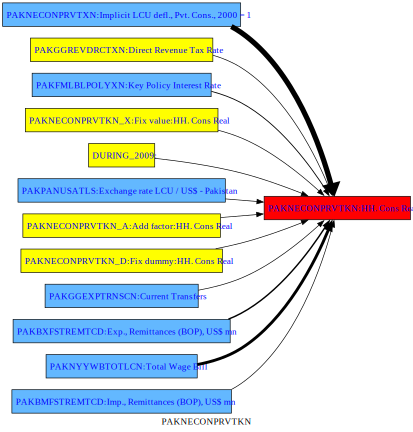

In [23]:
mpak.PAKNECONPRVTKN.tracepre()

## .tracepre() advanced

 - `fokus2all=True` will include a table of values for each variable 
 - `attshow = True` will include a table of attributions for each variable
 - `growthshow = True` will include a table of growth for each variable

 - `HR = True` will reorient the dependency graph 
 - 'up = <integer>` will determine how many levels of parents to include
 - `browser = True` will open a browser with the resulting dependency graph - useful for zooming on a big graph     

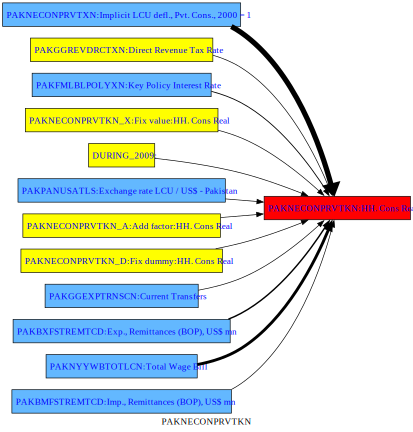

In [24]:
with mpak.set_smpl(2020,2023):
    mpak.PAKNECONPRVTKN.tracepre()

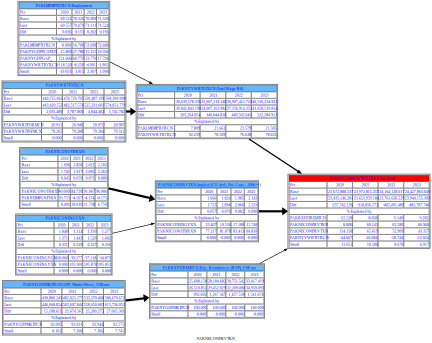

In [29]:
with mpak.set_smpl(2020,2023):
    mpak.PAKNECONPRVTKN.tracepre(fokus2all=True,HR=0,filter=20,
                                 attshow=1,up=2,browser=1,growthshow=0)

In [ ]:
%debug

## Attribution inflation - a problem with nonlinear equation (i think) 

The following single-equation decomposition looks to the impact on inflation.  The inflation equation is more complex and has more direct causal variables, so here the decomposition is more helpful.

Recall the inflation equation is given by the `.frml` method for its normalized version and `.eviews` for its original specification.  The equation for the consumer price level (PAKNECONPRVTXN) was originally specified in eviews as:

In [30]:
mpak['PAKNECONPRVTXN'].eviews

PAKNECONPRVTXN : @IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PAKCESENGYCON)  * PAKNECONENGYXN^(1  - PAKCESENGYCON)  + (PAKNECONOTHRSH^PAKCESENGYCON)  * PAKNECONOTHRXN^(1  - PAKCESENGYCON))^(1  / (1  - PAKCESENGYCON))


When normalized the equation solves for the **level** of the price deflator.  It is this normalized equation that is:

In [31]:
mpak.PAKNECONPRVTXN

Endogeneous: PAKNECONPRVTXN: Implicit LCU defl., Pvt. Cons., 2000 = 1
Formular: FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $

PAKNECONPRVTXN: Implicit LCU defl., Pvt. Cons., 2000 = 1
PAKCESENGYCON : 
PAKNECONENGYSH: 
PAKNECONENGYXN: 
PAKNECONOTHRSH: 
PAKNECONOTHRXN: 

Values :


,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Base,1.67,1.82,1.98,2.14,2.30,2.45,2.60,2.75,2.91,3.06,3.21
Last,1.72,1.89,2.07,2.23,2.39,2.55,2.70,2.86,3.00,3.15,3.30
Diff,0.06,0.07,0.08,0.09,0.10,0.10,0.10,0.10,0.10,0.10,0.09


Input last run:


,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
PAKCESENGYCON,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05,1.05
PAKNECONENGYSH,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
PAKNECONENGYXN,1.37,1.44,1.52,1.60,1.69,1.78,1.88,1.99,2.10,2.22,2.34
PAKNECONOTHRSH,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
PAKNECONOTHRXN,1.74,1.92,2.09,2.26,2.43,2.59,2.74,2.90,3.05,3.20,3.35


Because the normalized equation solves for the level of the price deflator, te decomposition will show the contributions of each explanatory variable to the increase in the price level (not that of the inflation rate).

Note in the Pakistan model, consumer inflation is derived as a CET aggregation of the price of energy goods(PAKNECONENGYXN) and non-energy goods (PAKNECONOTHRXN).

In [32]:
with mpak.set_smpl(2020,2025):
    mpak['PAKNECONPRVTXN'].dekomp()


Formula        : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $ 

                      2020       2021       2022       2023       2024       2025
Variable    lag                                                                  
Base        0         1.67       1.82       1.98       2.14       2.30       2.45
Alternative 0         1.72       1.89       2.07       2.23       2.39       2.55
Difference  0         0.06       0.07       0.08       0.09       0.10       0.10
Percent     0         3.40       3.84       4.11       4.21       4.18       4.06

 Contributions to differende for  PAKNECONPRVTXN
                         2020       2021       2022       2023       2024       2025
Variable       lag                                                                  
PAKNECONENGYSH 0        -0.00      -0.00      -0.00      -0.00      -0.00      

In [33]:
 mpak.PAKNECONPRVTXN.get_att(type='growth',bare=0)

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Growth percent,,,,,,,,,,,
Alternative,13.50%,9.94%,9.06%,8.09%,7.23%,6.55%,6.00%,5.57%,5.22%,4.95%,4.74%
Base,9.77%,9.48%,8.78%,7.98%,7.26%,6.67%,6.19%,5.79%,5.46%,5.19%,4.98%
Difference,3.73%,0.46%,0.28%,0.11%,-0.03%,-0.13%,-0.19%,-0.22%,-0.24%,-0.24%,-0.24%
PAKNECONENGYSH,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%
PAKCESENGYCON,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%
PAKNECONENGYXN,0.87%,0.79%,0.74%,0.69%,0.64%,0.60%,0.56%,0.52%,0.49%,0.46%,0.43%
PAKNECONOTHRSH,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%
PAKNECONOTHRXN,2.88%,3.30%,3.59%,3.71%,3.69%,3.58%,3.41%,3.21%,3.00%,2.78%,2.57%


Interestingly only 25% of the increase in the price level each period is due to the direct channel (the impact on energy prices), the bulk of the increase comes indirectly through other prices.  Indeed as time progresses this share rises from 75% in the first year of the price change (2020) to 86% by 2024.

Below is the formula for nonenergy consumer prices and its decomposition. This equation is written out as a more standard inflation equation reflecting changes in the cost of local goods production (PAKNYGDPFCSTXN), Government taxes on goods and services (PAKGGREVGNFSXN), the price of imports (PAKNEIMPGNGSXN) and the influence of the economic cycle (PAKNYGDPGAP_).

In [ ]:
mpak['PAKNECONOTHRXN'].eviews

In [ ]:
mpak.PAKNECONOTHRXN.get_att(2020,2090,type='growth',lag=0,threshold=0.0001,dec=None,bare=0)

In [ ]:
with mpak.set_smpl(2020,2025):
    mpak.PAKNECONOTHRXN.tracepre(filter=0.20,HR=1,fokus2all= True,attshow=True)

These results indicate that much of the initial impact on prices is coming the increase in the price of imported goods (which includes a large fuel component). As time progresses, the imported inflation component declines and the lagged consumption price dominates.  Other factors such as the cost of domestically produced goods play a larger role and the net impact of imported prices (the total of the contemporaneous and lagged value) approaches zero. Cyclical pressure are initially adding to inflation before declining and eventually turning negative.  

In [ ]:
mpak['PAKNECONOTHRXN'].dif.df

### Chart of the contributions over time 

```{admonition} Truncate attribution
:class: tip
Some equations have a lot of small contributions. These can be aggregated through the ```threshold=<some number>``` parameter. 
Variables for which all contributions are below the threshold will be lumped together in the **small** bin. Like below:
```

In [ ]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=False,rename=True,threshold=.02,lag=True); #decomp of teh change in the level

#### The lags can be aggregated 
Now it is obvious that most of the impact stems from one variable 

In [ ]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=True,rename=True,threshold=.02,lag=False); # expressed as a share (the conmtrinutions share)

#### The percent impact can be charted

In [ ]:
fig=mpak.dekomp_plot('PAKNYGDPFCSTXN',pct=True,rename=True,threshold=.02,lag=False);

In [ ]:
help(mpak.dekomp_plot)

### Chart of the contributions for one year
It can be useful to visualize the attribution as a waterfall chart for a single year

In [ ]:
mpak.dekomp_plot_per('PAKNYGDPFCSTXN',per=2029,threshold=5)  # gives a waterfall of contributions

#### The waterfall can be sorted

In [ ]:
mpak.dekomp_plot_per('PAKNYGDPFCSTXN',per=2029,threshold=5,sort=True)  # gives a waterfall of contributions


## Impacts at the model level: the `.totdif()` method 

The method `.totdif()` returns an instance  the totdif class, which provides a number of methods and properties to explore decomposition at the model level.

It works by solving the model numerous time, each time changing one of the right hand side variables and calculating the impact on the dependent variable. By default it uses the values from the `.lastdf` Dataframe as the shock values and the values in `.basedf` as the initial values.

For advanced users the RHS variables can be grouped into user defined blocks, which helps identify causal chains.

### Display the $\Delta$'s
This is done using the `.exodif()`Function. It will first find the exogenous variables where the values differ between 
`.lastdf`and `.basedf` and then return a dataframe with all the values which differs. 

In this case the dataframe contains the the effect of updating the $CO^2$ tax to 30 for coal, gas and oil. 

In [34]:
mpak.exodif()

,PAKGGREVCO2CER,PAKGGREVCO2GER,PAKGGREVCO2OER
2020,35.549839,71.000884,38.71065
2021,35.549839,71.000884,38.71065
2022,35.549839,71.000884,38.71065
2023,35.549839,71.000884,38.71065
2024,35.549839,71.000884,38.71065
...,...,...,...
2096,35.549839,71.000884,38.71065
2097,35.549839,71.000884,38.71065
2098,35.549839,71.000884,38.71065
2099,35.549839,71.000884,38.71065


### Now do the analyses
This involves solving the model a number of times, so 

In [35]:
totdekomp = mpak.totdif() # Calculate the total derivative½s of all equations in the model.

Total dekomp took       :         0.5184125900 Seconds


### .explain_all will visualize the results

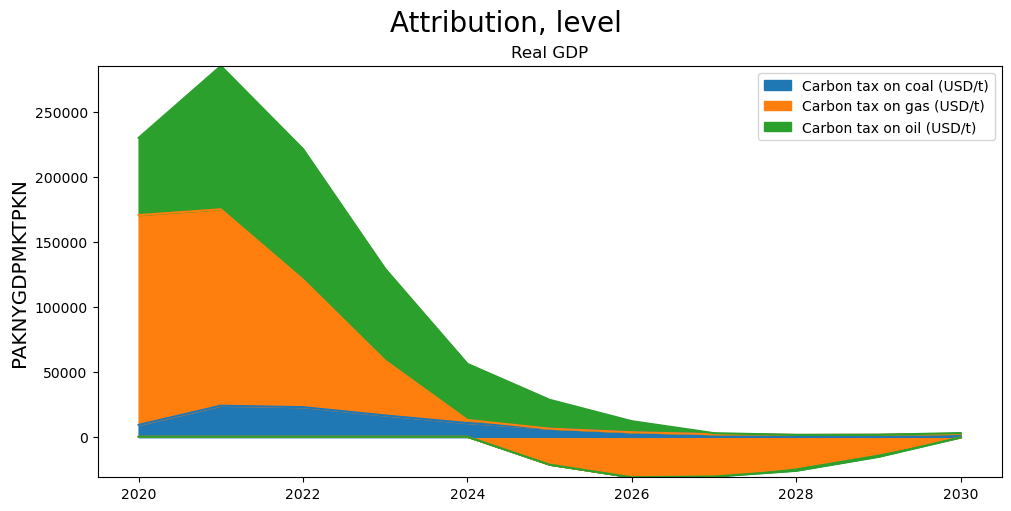

In [37]:
showvar = 'PAKNYGDPMKTPKN'
totdekomp.explain_all(showvar,kind='area',stacked=True) ;

### Many variables

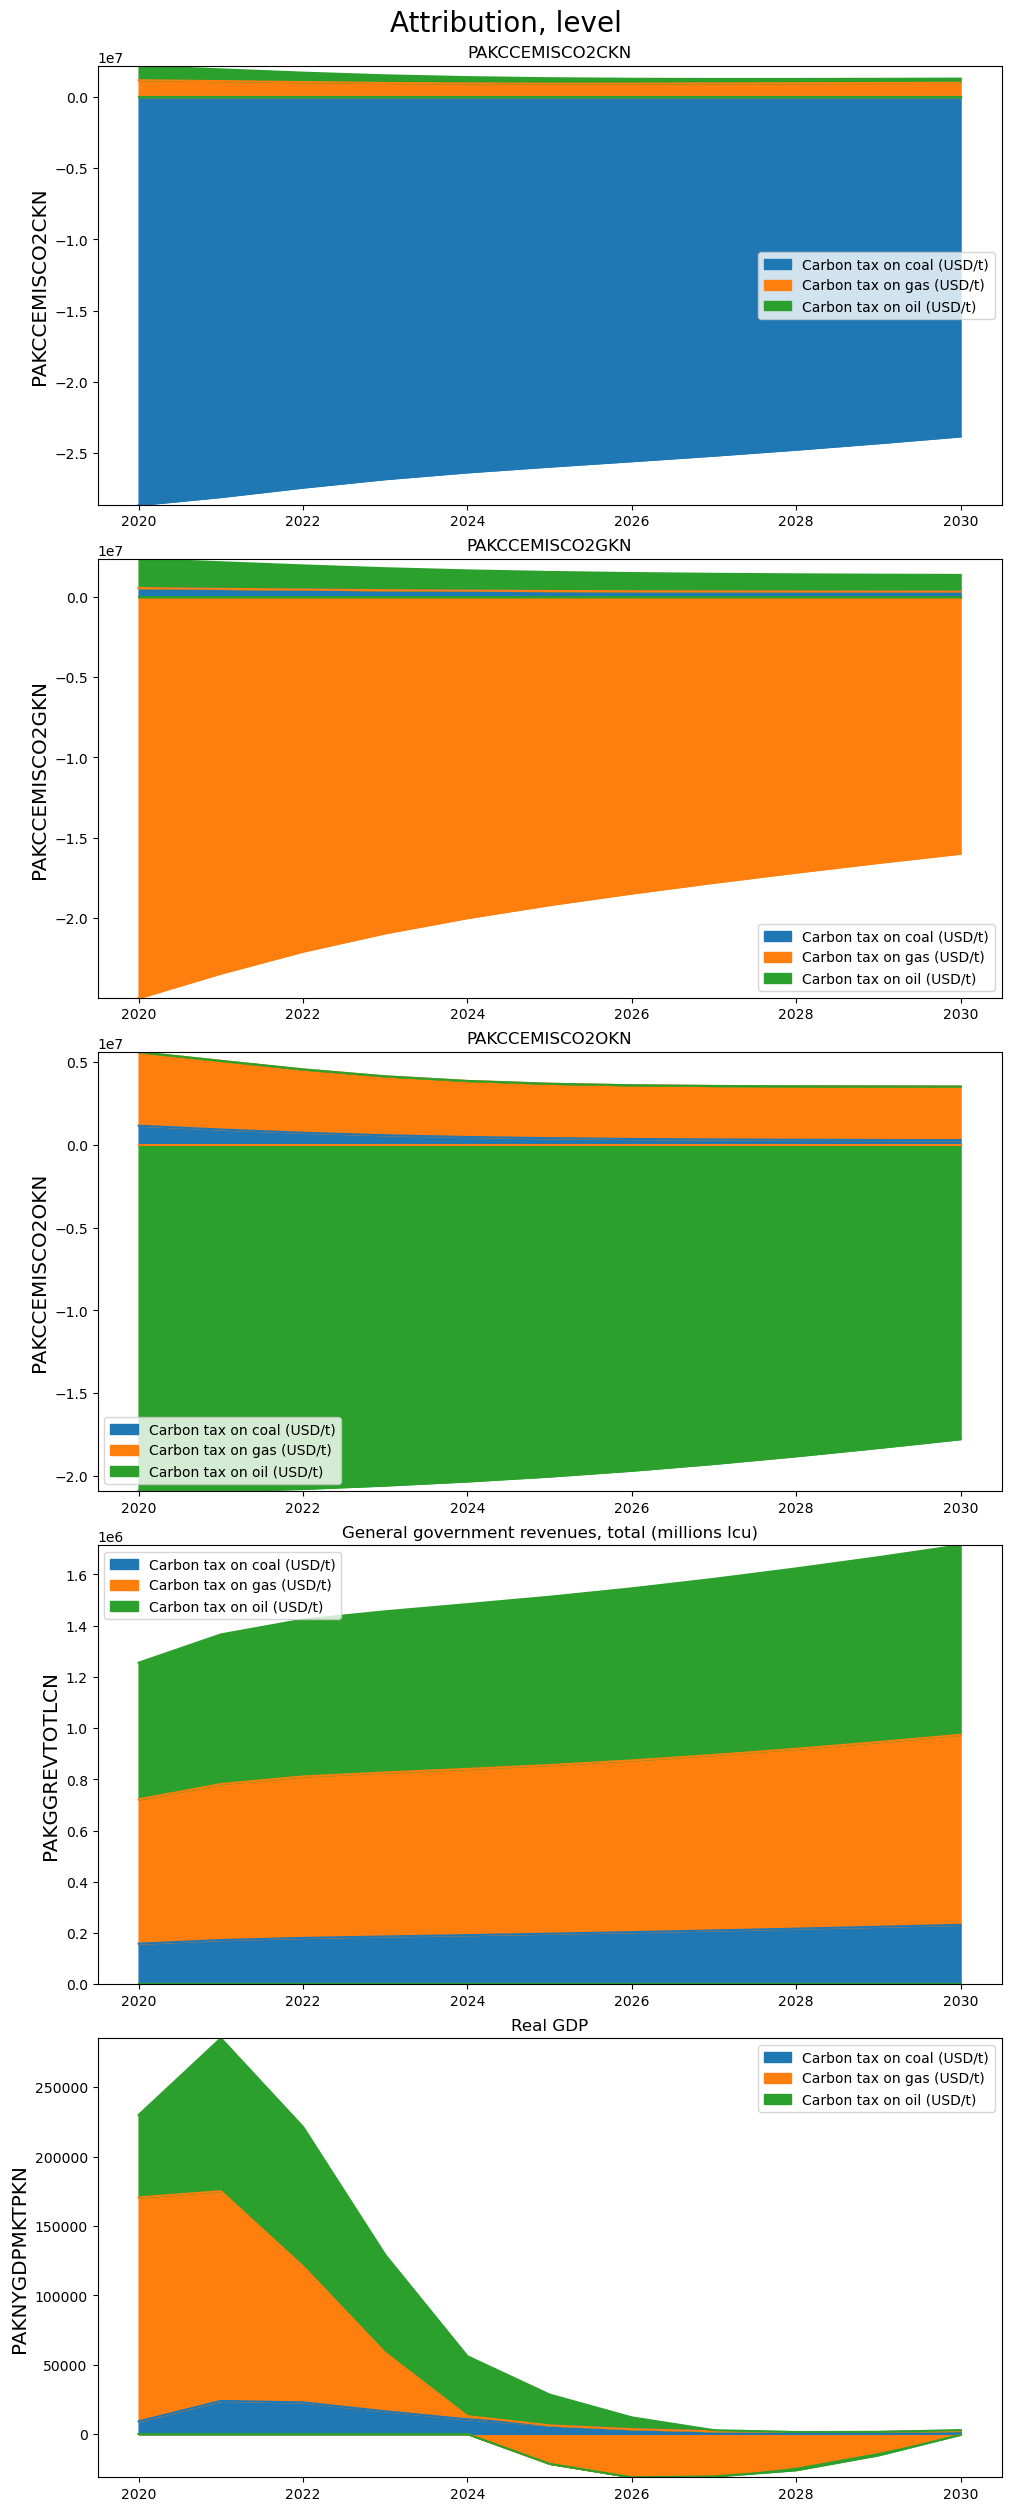

In [38]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'
totdekomp.explain_all(showvar,kind='area',stacked=True);    

### Charts for the contribution in one year

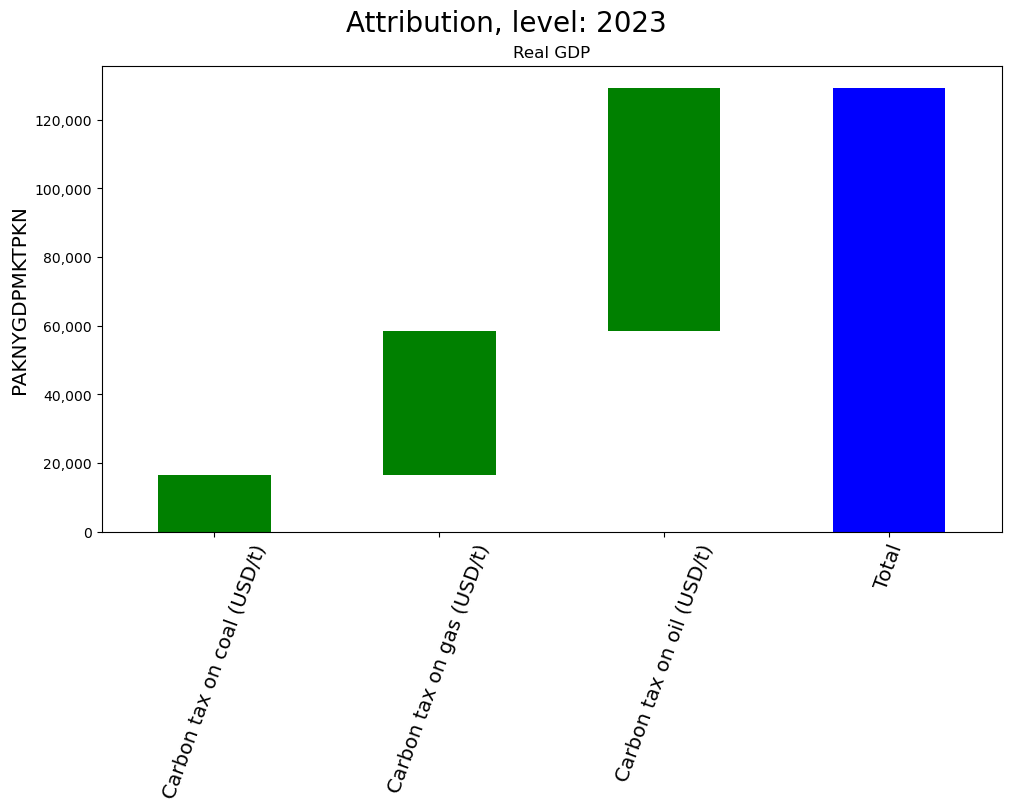

In [39]:
showvar = 'PAKNYGDPMKTPKN'

totdekomp.explain_per(showvar,per=2023,ysize=8)


### Or we can use interactive widgets
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [40]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7));

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

### Attribution of the last year 

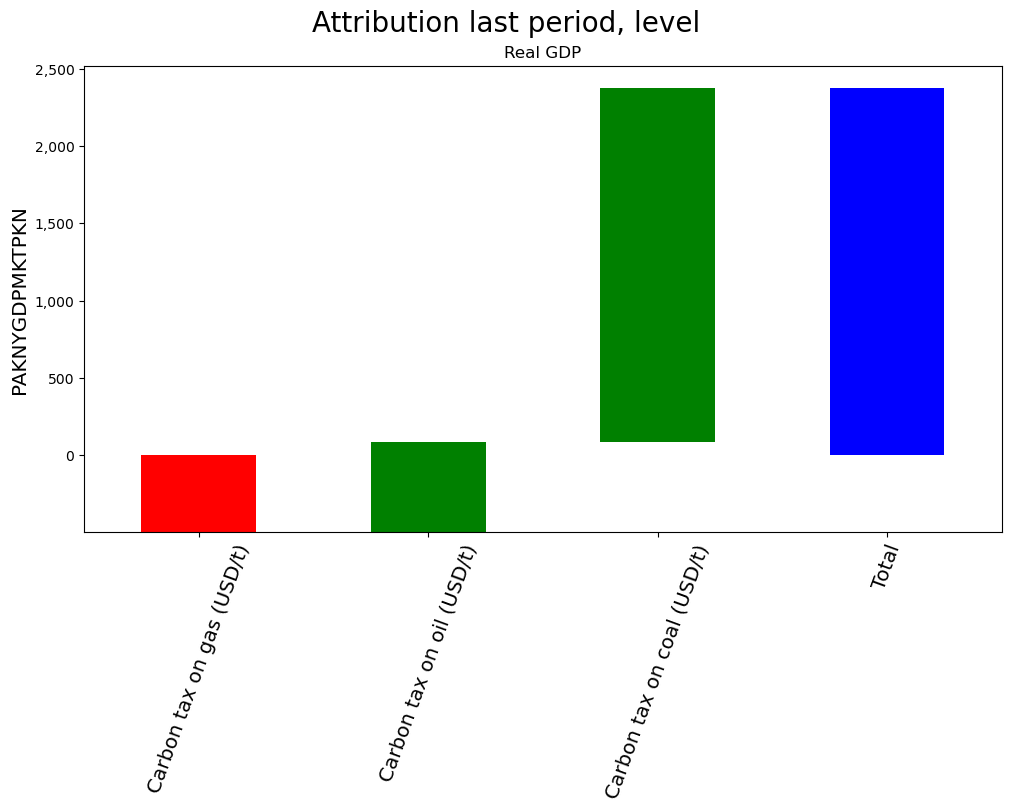

In [41]:
totdekomp.explain_last(showvar,ysize=8)

### Attribution of accumulated effects 

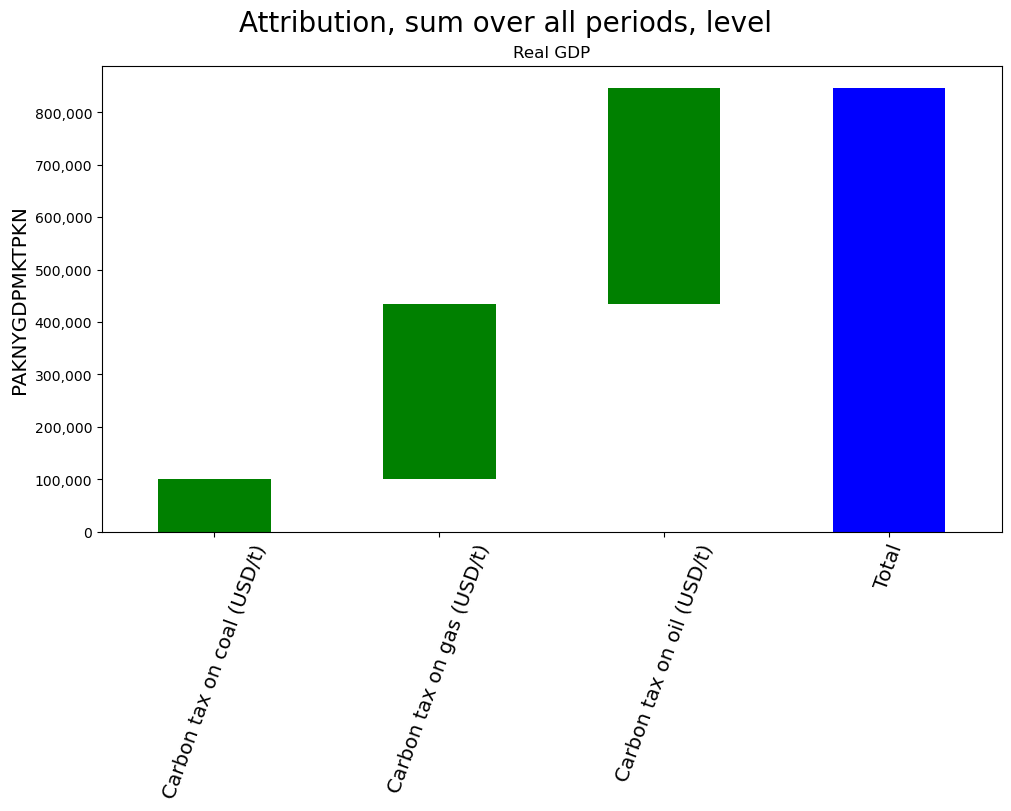

In [42]:
totdekomp.explain_sum(showvar,ysize=8)

## More advanced model attribution

For some  models (like the EBA bank stress test model) the number of changed exogenous variables can be large. Using a dictionary to contain the experiments allows us to create experiments where all variables for each country are analyzed, or each macro variable for all countries are analyzed. 

Also it is possible to use aggregated sums - useful for looking at impact on PD's. Or just the last time period - useful for looking at CET1 ratios. 

If there are many experiments, data can be filtered in order to look only at the variables with an impact above a certain threshold. 

The is also the possibility to   anonymize  the row and column names and to randomize
the order of rows and/or columns - useful for bank names. 

### Grouping variables
If two experiments differ by many exogenous variables it can make sense to group the variables into experiments. This allows the user to
slice and dice the impact along different dimensions. 

To illustrate this below you will find a model attribution where the impact of gas and coal tax is grouped together and the oil tax is in its own group. 

In [43]:
experiments = {'gas and coal':['PAKGGREVCO2CER', 'PAKGGREVCO2GER'],'Oil':['PAKGGREVCO2OER']}
totdekomp_group = mpak.totdif(experiments = experiments) # Calculate the total derivative½s of all equations in the model.

Total dekomp took       :         0.3625276089 Seconds


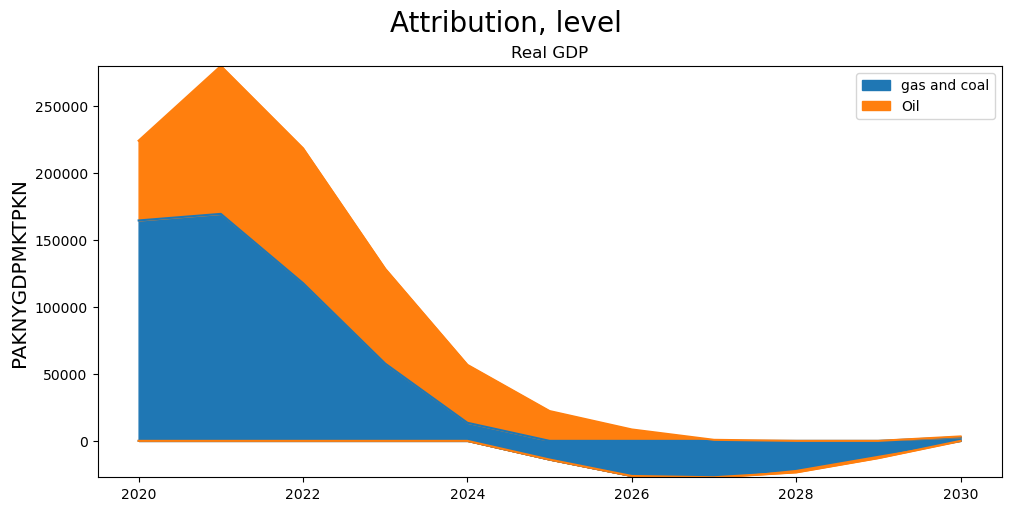

In [44]:
showvar = 'PAKNYGDPMKTPKN'
totdekomp_group.explain_all(showvar,kind='area',stacked=True);    

### Single equation attribution chart 
The results can be visualized in different ways. 

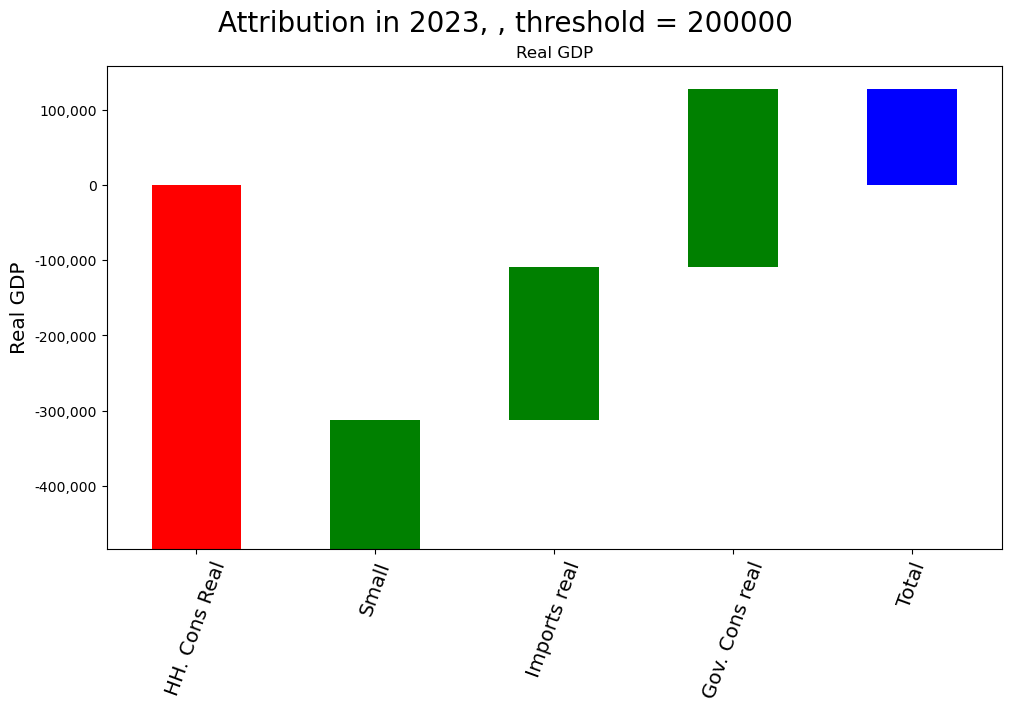

In [47]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2023,pct=0,rename=1,sort=1,threshold =200000,ysize=7)

### Attribution when comparing time frames 
In this case we seek to find out which variables explains the development from year to year. This is done only for the .lastdf dateframe. 

In [ ]:
with mpak.set_smpl(2020,2024):
    mpak['PAKNYGDPMKTPKN'].dekomp(time_att=True)

In [ ]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =0,time_att = True);

### Visualizing attribution in dependency graphs
The logical graph of the model can be used to show the upstream and downstream variable for a specific variable. More on this [here](../structure/Logical_structure.ipynb)<br>
When drawing the logical graph for a variable the model attribution will be used to guide the thickness of edges between nodes (variables). This enables a visual impression of which 
variables drives the impact. 

::: {note}
If png == 0 the graph below will be rendered in SVG format. This enables tooltips with additional information when the mouse hovers 
over an edge or an node. 

Unfortunately svg can't be displayed in the manual, so png has to be True for the manual. In a live jupyter notebook set latex=0. This will 
enable svg format. 
:::

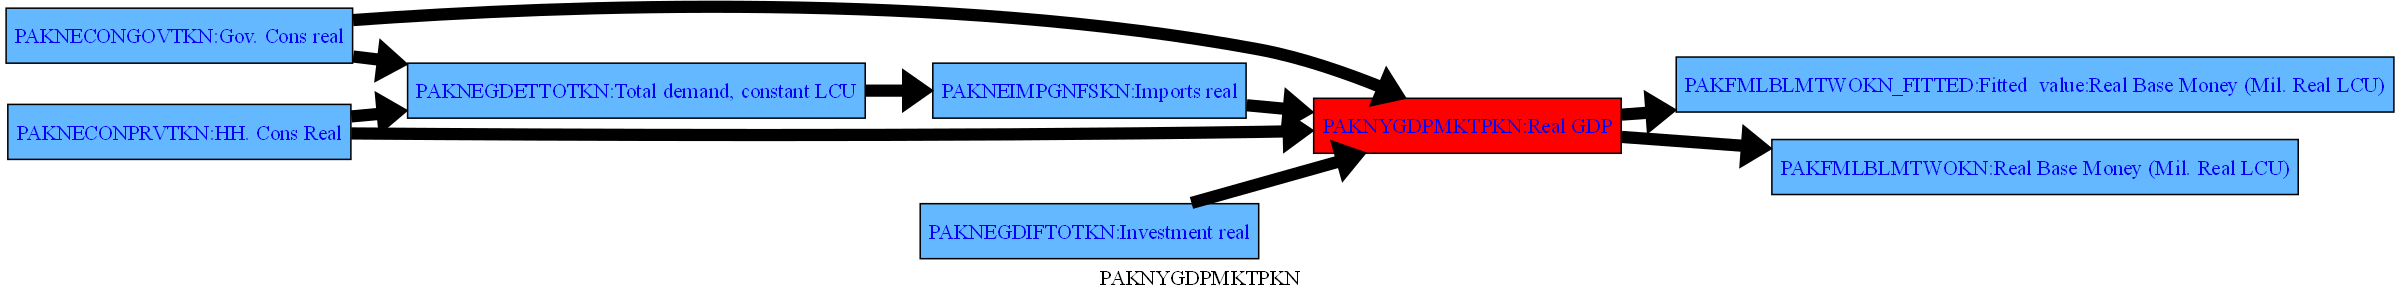

In [49]:
#mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=3,down=0,png=latex,filter=20) # For book
mpak['PAKNYGDPMKTPKN'].draw(up=3,down=1,png=latex,filter=400,svg=True,size=(8,40))#3 for interactice

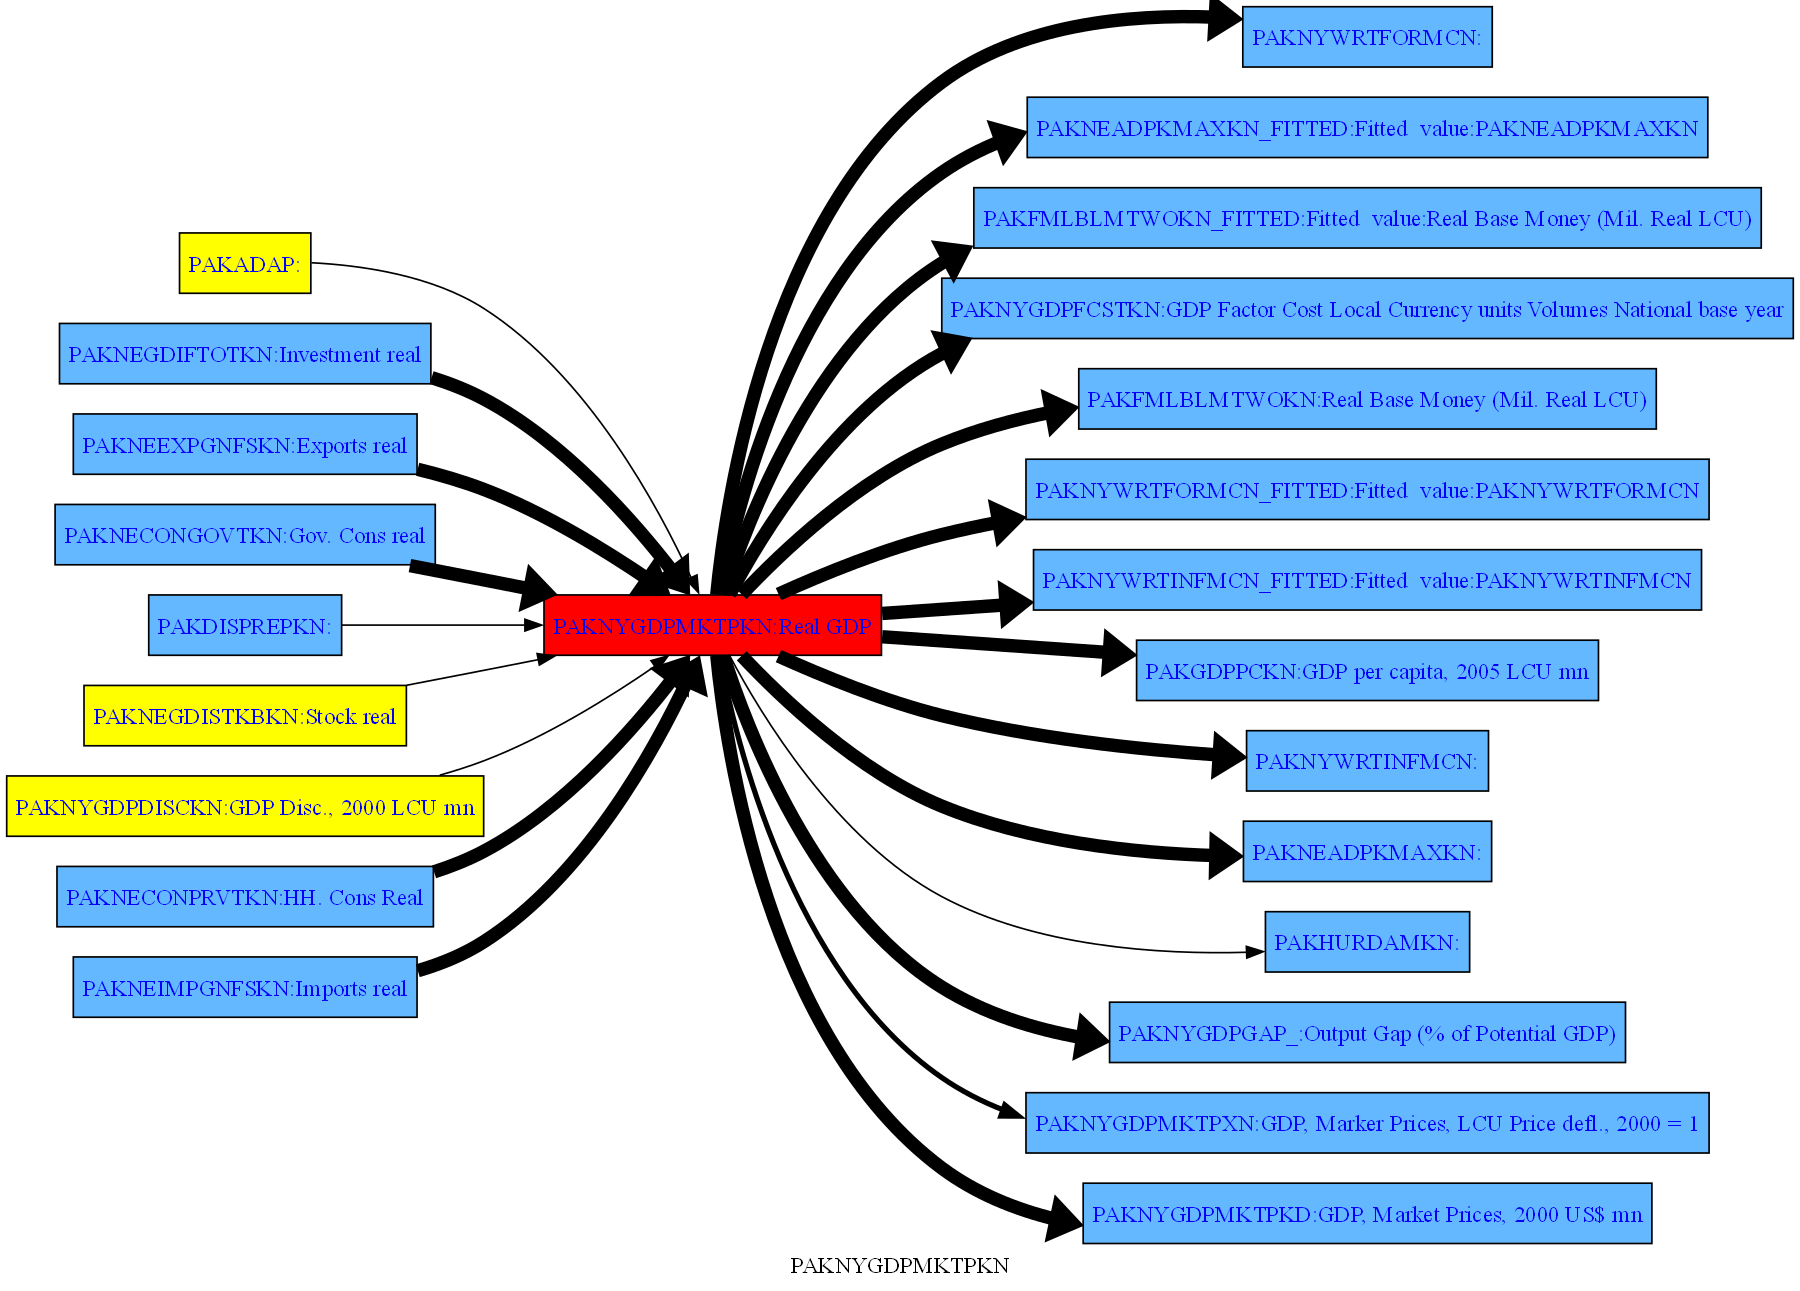

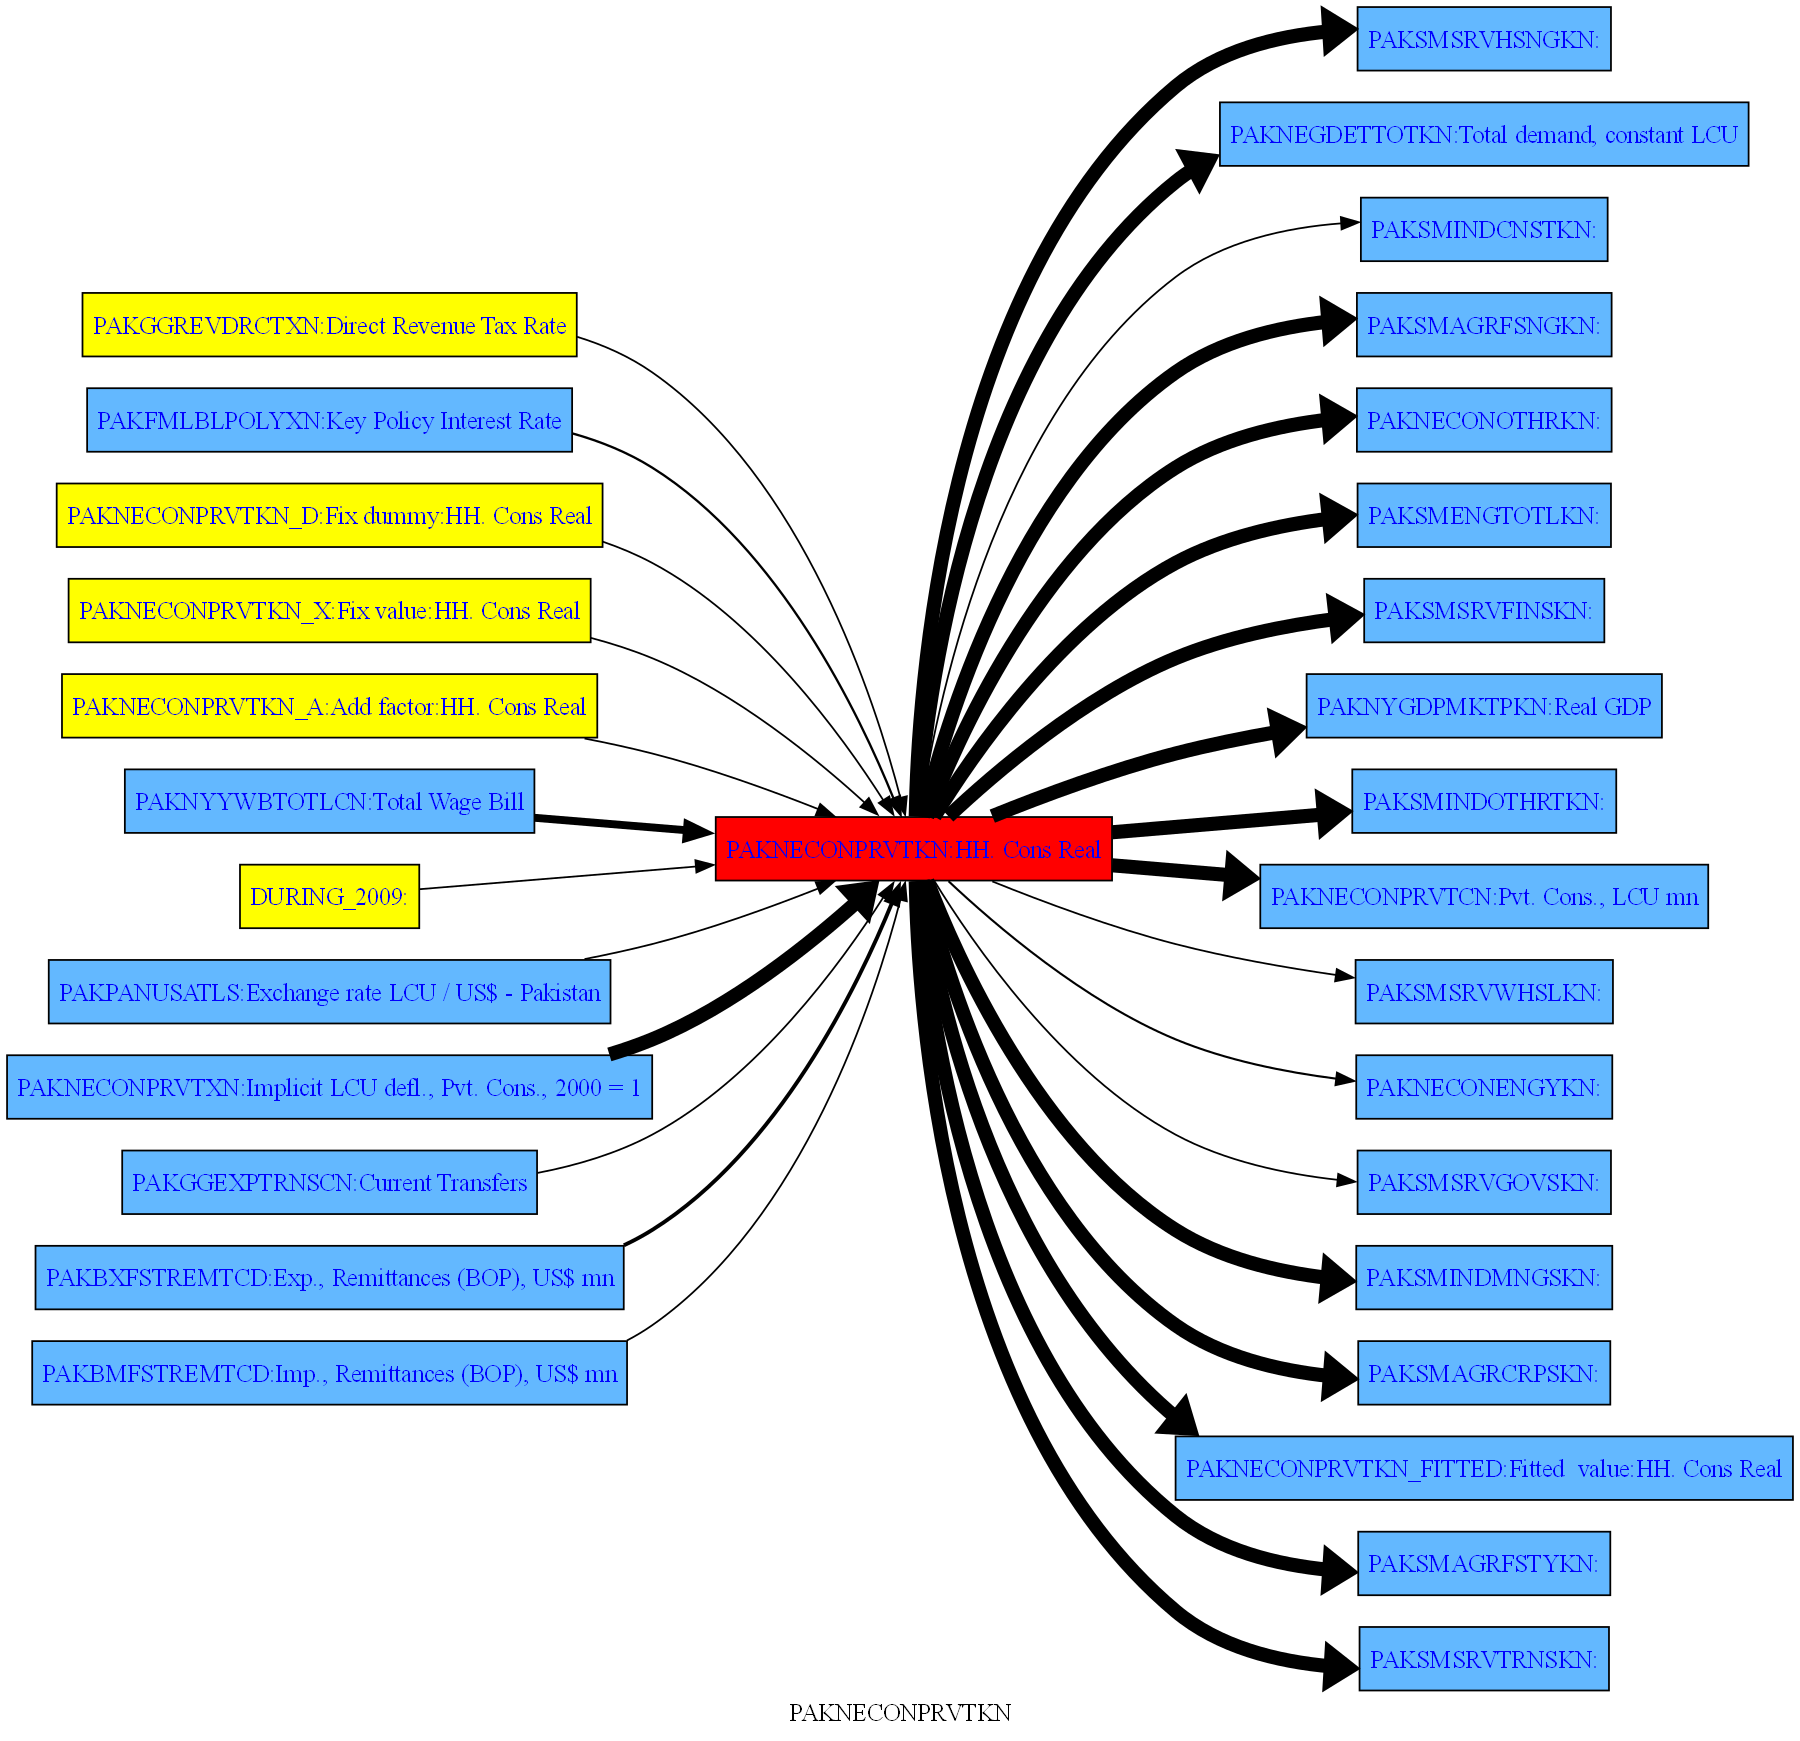

In [50]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram all direct dependencies 

### The attribution can be filtered and more levels can be displayed. 

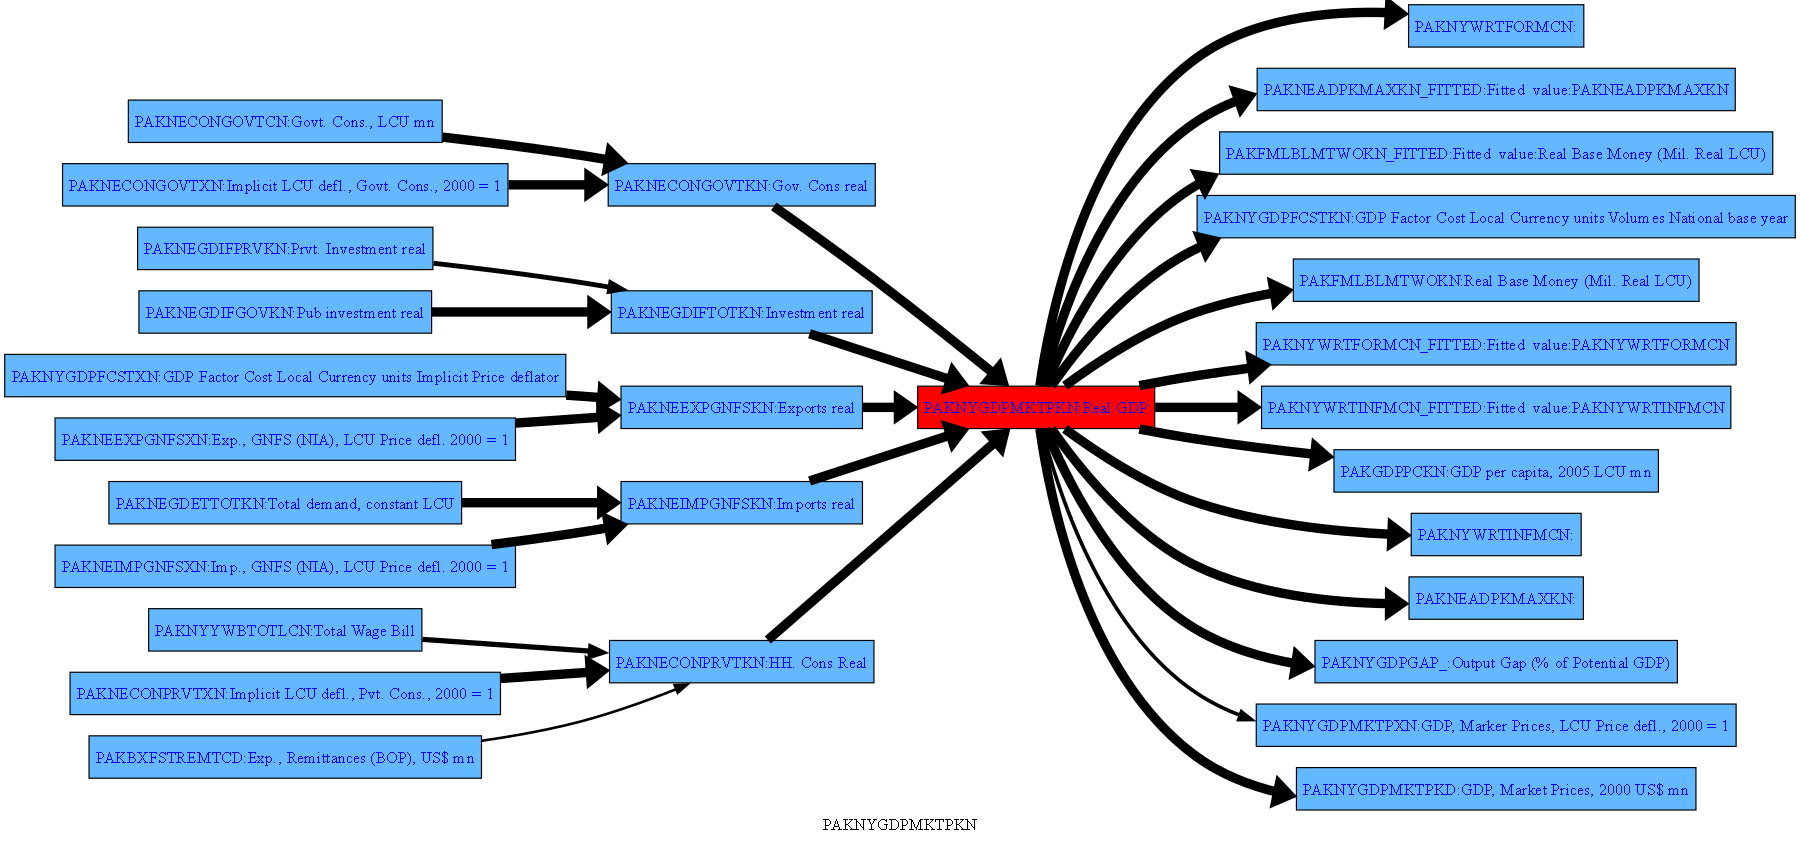

In [51]:
mpak['PAKNYGDPMKTPKN'].draw(up=2,down=1,png=latex,filter=20) 

### Or it can be used in a dashboard (not avaiable in the offline manual) 

In [ ]:

try:
    mpak.modeldash('PAKNYGDPMKTPKN',jupyter=1,inline=False)
except: 
    print('No Dashboard installed')